
# Stock Market Movement Prediction Using Economic Indicators, Technical Signals, and World Event Sentiment

## Introduction

This project explores the impact of economic data, stock technical indicators, and sentiment from world events on short-term stock price movements. The objective is to build a predictive model for daily buy/sell signals using SPY ETF data. 

## Data Sources

- **FRED** (Federal Reserve Economic Data): GDP, unemployment, CPI, and interest rate data.
- **Yahoo Finance**: SPY technical indicators including SMA, EMA, RSI, MACD, Bollinger Bands.
- **Wikipedia**: Global historical events scraped and scored for sentiment using NLP.

## Target Variable

The target will be a binary variable:
- **1 (Buy)**: if the SPY close price is greater than open (positive movement).
- **0 (Sell)**: if the SPY close is lower than or equal to the open.

This is based on the day-level close vs. open delta for SPY:  
**target = 1 if Close - Open > 0, else 0**

## Planned Model

A classification model (Random Forest or XGBoost) will be used. Preprocessing steps will include:
- Handling missing values
- Feature normalization (z-score)
- Date alignment for merging data
- Sentiment score processing

## Evaluation Metrics

- Confusion Matrix
- Accuracy
- Precision/Recall/F1 Score
- Feature importance for interpretation

---

The cells below contain data loading, transformation, and modeling logic for all three data sources.


# Cleaning/Formatting Flat File Source (Economic Data)
For this section, I will work on performing transformation and/or cleansing steps to Economic flat file data.

## Load necessary libraries

In [61]:
import pandas as pd
import os
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

## Load the datasets
All of the datasets are downloaded from the [**Federal Reserve Bank of St.Louis**](https://fred.stlouisfed.org/) in as CSV and they contain various kinds of Economic data released by the Federal Reserve. The date range of the datasets is from 01/01/2020 to 01/01/2025.

We will use os library to handle the files and load the files into DataFrames within a dictionary.

In [63]:
# Define folder path
folder_path = './flat_files'

# List all files in the folder
# files = os.listdir(folder_path)
files = [f for f in os.listdir(folder_path) if not f.startswith('.')] # Use the condition to exclude the hidden files

files

['Real Gross Domestic Product.csv',
 'Unemployment Rate.csv',
 'Federal Funds Effective Rate.csv',
 'Sticky Price Consumer Price Index.csv']

In [65]:
# Load the data from the files to the DataFrame

dfs = {} # Initializing the empty dictionary

for file in files:
    file_name = os.path.splitext(file)[0] # Split the file from its extension and get the file name
    file_path = os.path.join(folder_path, file)

    # Store DataFrame in dicionary with file name as the key
    dfs[file_name] = pd.read_csv(file_path)

Now that we have loaded the datasets into a dictionary of Dataframes, let's check one of them for preview.

In [68]:
dfs['Real Gross Domestic Product'].head()

,observation_date,A191RL1Q225SBEA
0,2020-01-01,-5.5
1,2020-04-01,-28.1
2,2020-07-01,35.2
3,2020-10-01,4.4
4,2021-01-01,5.6


One thing we can immediately notice is the column name of the GDP df is confusing which we need to transform into clearer name. This applies to all datasets of the Economics data. Another thing to notice is the date gap in the GDP is about 3 months, due to the release frequency of the data. We can propagate the data into other months and days based on the previous data for simplicity, so from 2020-01-01 to 2020-03-31 the GDP is -5.5 throughout the period.

## Data Transformations

### Step 1: Column Replacement
The column names of the data source are vague in terms of the representation as they are abbreviations. To make the data more understandable, let's take a look at the column names and update them as necessary.

In [70]:
# Print out the column names of the datasets
for dataset_name, df in dfs.items():
    print(f'{dataset_name}: {df.columns.tolist()}')

Real Gross Domestic Product: ['observation_date', 'A191RL1Q225SBEA']
Unemployment Rate: ['observation_date', 'UNRATE']
Federal Funds Effective Rate: ['observation_date', 'RIFSPFFNBWAW']
Sticky Price Consumer Price Index: ['observation_date', 'STICKCPIM157SFRBATL']


Let's now create a dictionary for each DataFrame where the keys are the original column names and the values are the new column names that we want to change to. 

In [72]:
rename_dict = {
    'Real Gross Domestic Product' : {'A191RL1Q225SBEA': 'gdp%change'},
    'Unemployment Rate' : {'UNRATE': 'unemloyment_rate'},
    'Federal Funds Effective Rate' : {'RIFSPFFNBWAW': 'fed_rate'},
    'Sticky Price Consumer Price Index': {'STICKCPIM157SFRBATL': 'cpi%change'}
}

In [74]:
# Loop through the DataFrames and apply the renaming
for dataset_name, df in dfs.items():
    if dataset_name in rename_dict:
        df.rename(columns = rename_dict[dataset_name], inplace=True)

In [76]:
# Lastly, let's change the 'observation_date' column to econ_date for easier reference later when we merge the DataFrames
general_rename_dict = {'observation_date': 'econ_date'}

for dataset_name, df in dfs.items():
    df.rename(columns = general_rename_dict, inplace = True)

In [78]:
# Check the updated column names
for dataset_name, df in dfs.items():
    print(f'{dataset_name}: {df.columns.tolist()}')

Real Gross Domestic Product: ['econ_date', 'gdp%change']
Unemployment Rate: ['econ_date', 'unemloyment_rate']
Federal Funds Effective Rate: ['econ_date', 'fed_rate']
Sticky Price Consumer Price Index: ['econ_date', 'cpi%change']


### Step 2: Data Type Conversion
Now that we have changed the column names to more human-readable format, let's make sure the data types of each column is in proper format and update otherwise.

In [81]:
# Check the data type of each column of the dataframes
for dataset_name, df in dfs.items():
    print(f"Data types in '{dataset_name}':")
    print(df.dtypes)
    print('\n')

Data types in 'Real Gross Domestic Product':
econ_date      object
gdp%change    float64
dtype: object


Data types in 'Unemployment Rate':
econ_date            object
unemloyment_rate    float64
dtype: object


Data types in 'Federal Funds Effective Rate':
econ_date     object
fed_rate     float64
dtype: object


Data types in 'Sticky Price Consumer Price Index':
econ_date      object
cpi%change    float64
dtype: object




Obviously, there are a few columns that we need to change the data type, especially the date column of each dataframe. 

In [84]:
# Convert the date column to datetime format
for dataset_name, df in dfs.items():
    if 'econ_date' in df.columns and df['econ_date'].dtype == 'object':
        df['econ_date'] = pd.to_datetime(df['econ_date'], format ='%Y-%m-%d', errors = 'raise')
        print(f"Converted 'date' column to datetime in '{dataset_name}'")

Converted 'date' column to datetime in 'Real Gross Domestic Product'
Converted 'date' column to datetime in 'Unemployment Rate'
Converted 'date' column to datetime in 'Federal Funds Effective Rate'
Converted 'date' column to datetime in 'Sticky Price Consumer Price Index'


In [86]:
# Check the updated data
for dataset_name, df in dfs.items():
    print(f"Head of the data in '{dataset_name}':")
    print(df.head())
    print('\n')

Head of the data in 'Real Gross Domestic Product':
   econ_date  gdp%change
0 2020-01-01        -5.5
1 2020-04-01       -28.1
2 2020-07-01        35.2
3 2020-10-01         4.4
4 2021-01-01         5.6


Head of the data in 'Unemployment Rate':
   econ_date  unemloyment_rate
0 2020-01-01               3.6
1 2020-02-01               3.5
2 2020-03-01               4.4
3 2020-04-01              14.8
4 2020-05-01              13.2


Head of the data in 'Federal Funds Effective Rate':
   econ_date  fed_rate
0 2020-01-01      1.55
1 2020-01-15      1.55
2 2020-01-29      1.55
3 2020-02-12      1.59
4 2020-02-26      1.58


Head of the data in 'Sticky Price Consumer Price Index':
   econ_date  cpi%change
0 2020-01-01     0.27147
1 2020-02-01     0.19426
2 2020-03-01     0.02666
3 2020-04-01    -0.14748
4 2020-05-01     0.02364




### Step 3: Find Duplicates
Since the Economic data comes from the Federal Reserve at different frequencies, there could be duplicated records if there's any data entry error or other type of errors. Let's check the duplicates now. Since all the data are time-series-based and only has one numeric column, we only need to check the date column for duplicates.

In [89]:
for dataset_name, df in dfs.items():
    duplicate_count = df[df.duplicated(subset = 'econ_date', keep=False)] # Use the keep=False parameter to get all duplicates
    num_duplicates = duplicate_count.shape[0]
    print(f"Dataset '{dataset_name}' has {num_duplicates} duplicates based on the 'date' column.")

Dataset 'Real Gross Domestic Product' has 0 duplicates based on the 'date' column.
Dataset 'Unemployment Rate' has 0 duplicates based on the 'date' column.
Dataset 'Federal Funds Effective Rate' has 0 duplicates based on the 'date' column.
Dataset 'Sticky Price Consumer Price Index' has 0 duplicates based on the 'date' column.


Fortunately, there is no duplicate in all of the dataframes.

### Step 4: Handling Null Values
Now let's check the number of null values in each column of the dataframes and decide on how we should handle them acccordingly.

In [94]:
all_no_nulls = True  # Flag to track if all DataFrames have no nulls

for dataset_name, df in dfs.items():
    null_counts = df.isnull().sum()  # Count the number of null values for each column
    total_rows = df.shape[0]
    null_percentage = (null_counts / total_rows) * 100

    if null_counts.any() > 0:
        all_no_nulls = False  # Set flag to False if any nulls are found
        print(f"Null values counts and percentages for dataset '{dataset_name}':")
        null_info = pd.DataFrame({'Null Count': null_counts, 'Null Percentage': null_percentage})
        print(null_info[null_info['Null Count'] > 0])
        print('\n')

if all_no_nulls:
    print("There's no null values in all DataFrames.")

There's no null values in all DataFrames.


### Step 5: Checking Outliers
Although the data released by the Federal Reserve is public and they are major data points of the Economy thus not likely to have data entry errors, let's still check the outliers.

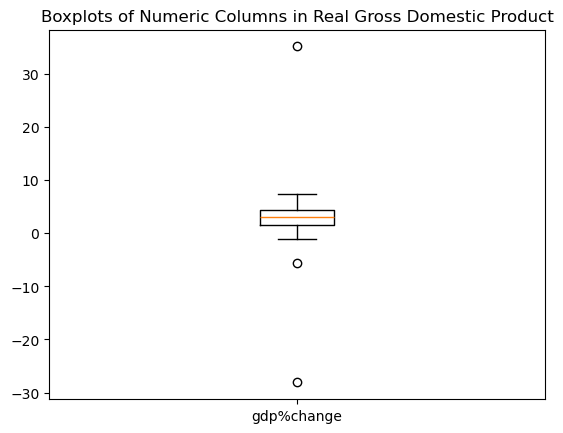

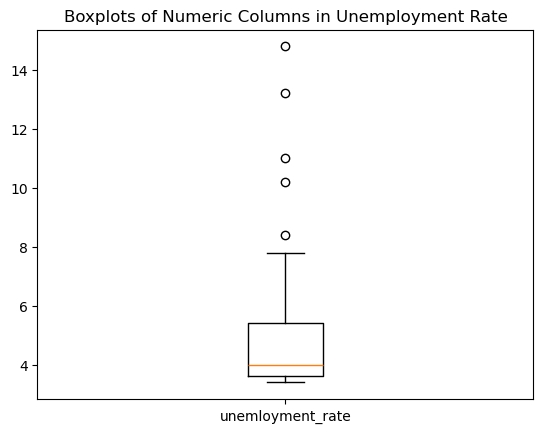

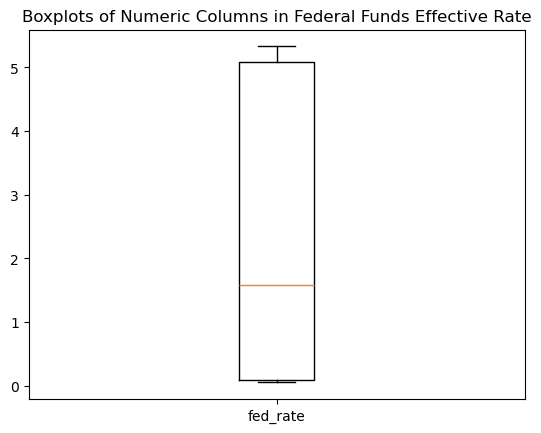

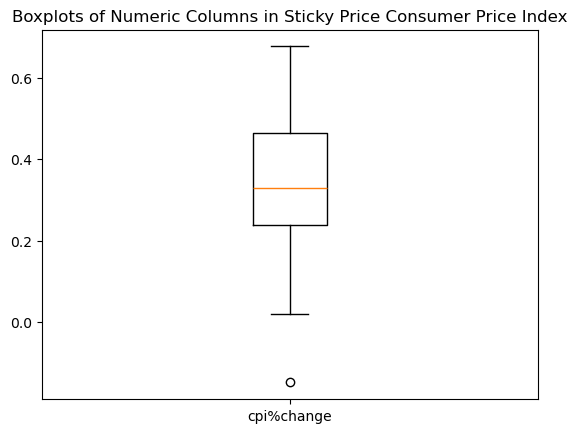

In [97]:
for dataset_name, df in dfs.items():
    numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

    if numeric_columns:
        valid_data = []

        for col in numeric_columns:
            clean_data = df[col].dropna()
            valid_data.append(clean_data)
        
        plt.boxplot(valid_data, labels=numeric_columns)
        plt.title(f"Boxplots of Numeric Columns in {dataset_name}")
        plt.show()

Three of them have outliers according to the box plots. They are most likely due to natural reasons. Let's take a look at the unemloyment rate to explore a little.

In [103]:
# Let's query some of the outlier example based on the chart
dfs['Unemployment Rate'][dfs['Unemployment Rate']['unemloyment_rate'] >= 10] 

,econ_date,unemloyment_rate
3,2020-04-01,14.8
4,2020-05-01,13.2
5,2020-06-01,11.0
6,2020-07-01,10.2


The extremes are very resonable given the fact they were during the Covid breakout periods. I validated by Google Search and did find similar number from the [**Department of Labor website**](https://www.dol.gov/sites/dolgov/files/OPA/newsreleases/ui-claims/20200551.pdf).

### Step 6: Merging/Joinining DataFrames
The dataframes have different date granularities, as some of the data are released monthly, some bi-weekly, and some quarterly. Monthly and quarterly data are released first day of the month, and bi-weekly data does not gurantee data for first day of every month. Since the end goal of the project is to analyze the impact of Economic, world data, as well as technical indicators on the performance of stock price, the Economic data should be used in the right join for analysis. As a result, we could create a date column as the base table and left join all the dataframes to be used later with the stock data.

In [107]:
# Create the base dataframe
date_range = pd.date_range(start = '2020-01-01', end = '2025-01-01', freq = 'D')
df_econ = pd.DataFrame({'econ_date': date_range})
print(f'Dimension of the date dateframe: {df_econ.shape}')
df_econ.head()

Dimension of the date dateframe: (1828, 1)


,econ_date
0,2020-01-01
1,2020-01-02
2,2020-01-03
3,2020-01-04
4,2020-01-05


In [109]:
# Perform left joins with all DataFrames in the dfs dictionary
for dataset_name, df in dfs.items():
    df_econ = df_econ.merge(df, on = 'econ_date', how='left')

print(f'Dimension of the joined dateframe: {df_econ.shape}')
df_econ.head()

Dimension of the joined dateframe: (1828, 5)


,econ_date,gdp%change,unemloyment_rate,fed_rate,cpi%change
0,2020-01-01,-5.5,3.6,1.55,0.27147
1,2020-01-02,NaN,NaN,NaN,NaN
2,2020-01-03,NaN,NaN,NaN,NaN
3,2020-01-04,NaN,NaN,NaN,NaN
4,2020-01-05,NaN,NaN,NaN,NaN


Let's check the null count in each column.

In [112]:
null_counts = df_econ.isnull().sum()
print(null_counts)

econ_date              0
gdp%change          1807
unemloyment_rate    1767
fed_rate            1697
cpi%change          1767
dtype: int64


Now as discussed earlier, let's use the forward fill method to fill the NAs the propagate the last valid obervation forward to fill nulls until a new non-null value is encountered. Since our DataFrame is date-based and we want to ensure the fill respects the order of dates, we should sort by econ_date first.

In [116]:
df_econ = df_econ.sort_values('econ_date')
df_econ = df_econ.fillna(method='ffill')

Re-check the null count in each column.

In [121]:
null_counts = df_econ.isnull().sum()
print(null_counts)

econ_date           0
gdp%change          0
unemloyment_rate    0
fed_rate            0
cpi%change          0
dtype: int64


In [482]:
# print the head of the Econ Data for reference later
df_econ.head()

,econ_date,gdp%change,unemloyment_rate,fed_rate,cpi%change
0,2020-01-01,-5.5,3.6,1.55,0.27147
1,2020-01-02,-5.5,3.6,1.55,0.27147
2,2020-01-03,-5.5,3.6,1.55,0.27147
3,2020-01-04,-5.5,3.6,1.55,0.27147
4,2020-01-05,-5.5,3.6,1.55,0.27147


---
---
---

# Cleaning/Formatting Website Data (World Events)
For this section, I will work on performing data transformation and/or cleansing steps to Website Data that contains the world events, and also deriving the sentiment scores from the events.

## Load necessary libraries

In [165]:
import requests
from bs4 import BeautifulSoup
pd.set_option('display.max_colwidth', None)
import re
import string

## Review the html page, extract related data, and creating DataFrame from the data
The world event wikipedia page has the html url in the format of 'https://en.wikipedia.org/wiki/<year>' for which I can enter different year number for extraction of the major world events of the year. Since we extracted the US economy data from the Federal Reserve Bank of St.Louis from 01/01/2020 to 01/01/2025, I will align with this date range in this section. However, since the world events data source is broken into yearly sections, I will extract only 2020 - 2024 to avoid unnecessary data wrangling and code comeplexity for that only 1 day in 2025.

Let's try and work on the 2020 data first.

In [438]:
# Fetch the HTML content
url = "https://en.wikipedia.org/wiki/2020"
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")

Using ctrl + u to open the source of the webpage, the 'Events' section is on line 1156 with h2 id="Events", which will be helpful for me to extract the related data.

In [441]:
# Look for the Events section
events_section_header = soup.find("h2", id = "Events")
if events_section_header:
    events_section = events_section_header.find_next("ul")
else:
    raise Exception("Could not find the 'Events' section on the page.")

According to the source, each month has h3 tag with an ID, and each day's events are listed in nested \<ul\> and \<li\> tags, with multiple events possible per day. For days with only one event, the event description is part of the \<li\> tag itself, instead of a nested \<ul\> with multiple \<li\> tags. We will need to handle both formats: one for days with a single events and another for days with multiple events.

Another difficulty is that for instance January 2, 2020 that had one event of that day, the event text from the source contains multiple links \(\<a\> tags\), and simply extracting the next sibling text will not be efficient to capture the entire event description. Therefore, I will need to extract the entire content of the \<li\> tag for single events, including the text inside nested tags like \<a\> and then concatenate all text within the tag.

In [444]:
# Extract the dates and event text

# Create a list of all months in the 'Events' section
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

data = []
year = 2020 # Let's only explore the year of 2020 for the moment before we move on with other years

# Loop through each month and extract events
for month in months:
    month_header = soup.find("h3", id = month) # Find the <h3> tag for the current month

    if month_header:
        events_section = month_header.find_next("ul") # Find the next <ul> that contains the events for this month

        # Loop through each <li> element inside the <ul> (this is where the events are listed)
        for li in events_section.find_all("li", recursive=False):
            date_tag = li.find("a") # The <a> tag inside <li> contains the date link
            if date_tag:
                date = date_tag.get_text() # Get the date 

                # Check if there are multiple events (nested <ul> inside the <li>)
                event_list = li.find("ul")
                if event_list:
                    for event_li in event_list.find_all("li"): # Multiple events for this day, loop through each event <li>
                        event_text = event_li.get_text()

                        data.append({
                            "year": year,
                            "month": month,
                            "date": date,
                            "event": event_text.strip()  # Strip the text to remove unnecessary white spaces
                        })
                else:  # For single event dates as there's no "ul"
                    event_text = ' '.join(li.stripped_strings) # Combine all text and links in the <li> tag
                    event_text = event_text.replace(f'{date} – ','')  # Remove the data part from the event text
                    if event_text:
                        data.append({
                            "year": year,
                            "month": month,
                            "date": date,
                            "event": event_text.strip() 
                        })

# Convert the data to DataFrame
df = pd.DataFrame(data)  

In [446]:
# Validate the data, focusing on January
df[df.month=='January']

,year,month,date,event
0,2020,January,January 1,Croatia begins its term in the presidency of the European Union.[6]
1,2020,January,January 1,"Flash floods struck Jakarta, Indonesia, killing 66 people in the worst flooding in over a decade.[7]"
2,2020,January,January 2,The Royal Australian Air Force and Navy are deployed to New South Wales and Victoria to assist mass evacuation efforts amidst the 2019–20 Australian bushfire season . [ 8 ] [ 9 ]
3,2020,January,January 3,"A United States drone strike at Baghdad International Airport kills ten people, including the intended target, an Iranian general. Qasem Soleimani and Iraqi paramilitary leader Abu Mahdi al-Muhandis . [ 10 ]"
4,2020,January,January 5,Second Libyan Civil War: President Recep Tayyip Erdoğan announces the deployment of Turkish troops to Libya on behalf of the United Nations-backed Government of National Accord.[11]
5,2020,January,January 5,"2019–20 Croatian presidential election: The second round of voting is held, and Zoran Milanović of the Social Democratic Party of Croatia defeats incumbent president Kolinda Grabar-Kitarović.[12]"
6,2020,January,January 8,"Iran launches ballistic missiles at two Iraqi military bases hosting U.S. soldiers, injuring over 100 personnel.[13]"
7,2020,January,January 8,"Ukraine International Airlines Flight 752 was shot down by Iranian forces shortly after takeoff from Tehran Imam Khomeini International Airport, killing all 176 people on board.[14]"
8,2020,January,January 9,"A rare, circumbinary planet called TOI 1338-b is discovered.[15]"
9,2020,January,January 9,"Islamic State millitants in the Greater Sahara assaulted a Nigerien military base in Chinagodrar, killing at least 89 Nigerien soldiers.[16]"


According to my mannual validation above, the data output returns expected results and we are good to move on with populating the data from the complete five years: from 2020 to 2024, looping through each year in that range and fetch the corresponding Wikipedia page for each year. Additionally, I’ll incorporate a clean_event_text function to clean the event text (removing citations, punctuation, extra spaces, and converting to lowercase).

In [448]:
# Define a function to clean up the 'event' text
def clean_event_text(text):
    text = re.sub(r'\[\s*\d+\s*\]','', text)  # Remove citation numbers like [6], [ 8 ], etc.
    text = re.sub(f'[{re.escape(string.punctuation)}]','', text)  # Remove all punctuation marks
    text = re.sub(r'\s+',' ', text).strip()  # Remove extra spaces and trim the text
    text = text.lower()  # Convert to lowercase
    return text

# Initialize data list to store all events
data = []

# Define the years to extract (2020 to 2024)
years = range(2020, 2025)

# List of months
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

# Loop through each year
for year in years:
    # Fetch the HTML content for the year's Wikipedia page
    url = f"https://en.wikipedia.org/wiki/{year}"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    # Look for the Events section
    events_section_header = soup.find("h2", {"id": "Events"})
    if not events_section_header:
        print(f"Could not find the 'Events' section for {year}. Skipping...")
        continue

    # Loop through each month and extract events
    for month in months:
        month_header = soup.find("h3", {"id": month})  # Find the <h3> tag for the current month
        if not month_header:
            print(f"No {month} section found for {year}. Skipping...")
            continue

        events_section = month_header.find_next("ul")  # Find the next <ul> that contains the events for this month
        if not events_section:
            print(f"No events list found for {month} {year}. Skipping...")
            continue

        # Loop through each <li> element inside the <ul>
        for li in events_section.find_all("li", recursive=False):
            # Extract the full text of the <li> to search for the date
            li_text = ' '.join(li.stripped_strings)

            # Use regex to find the date or date range (e.g., "October 1" or "October 3–20")
            date_match = re.match(rf"{month}\s+\d{{1,2}}(?:–\d{{1,2}})?", li_text)
            date = date_match.group(0) if date_match else None

            # Check for nested <ul> (multiple events for a single date)
            event_list = li.find("ul")
            if event_list:
                # Handle multiple events for this date
                for event_li in event_list.find_all("li", recursive=False):
                    event_text = ' '.join(event_li.stripped_strings)
                    event_text = clean_event_text(event_text)
                    if event_text and date:
                        data.append({
                            "year": year,
                            "month": month,
                            "date": date,
                            "event": event_text
                        })
                    else:
                        print(f"Skipped nested event in {month} {year}: date={date}, text={event_text}")
            else:
                # Handle single event (no nested <ul>)
                event_text = li_text
                if date:
                    # Remove the date prefix (e.g., "October 1 – ")
                    event_text = re.sub(rf'^{re.escape(date)}\s*[–-]\s*', '', event_text)
                event_text = clean_event_text(event_text)
                if event_text:
                    # Fallback to month if no date found
                    date = date or month
                    data.append({
                        "year": year,
                        "month": month,
                        "date": date,
                        "event": event_text
                    })
                else:
                    print(f"Skipped single event in {month} {year}: date={date}, text={event_text}")

# Convert the data to DataFrame
df = pd.DataFrame(data)

Skipped nested event in July 2024: date=None, text=global it outages impact a variety of businesses and organisations across the world
Skipped nested event in July 2024: date=None, text=75 people are killed during the 2024 bangladesh quota reform movement the government of bangladesh imposes a curfew


Now that we get the data from 2020 to 2024. Let's do some simple validation.

In [452]:
# check the df head
df.head()

,year,month,date,event
0,2020,January,January 1,croatia begins its term in the presidency of the european union
1,2020,January,January 1,flash floods struck jakarta indonesia killing 66 people in the worst flooding in over a decade
2,2020,January,January 2,the royal australian air force and navy are deployed to new south wales and victoria to assist mass evacuation efforts amidst the 2019–20 australian bushfire season
3,2020,January,January 3,a united states drone strike at baghdad international airport kills ten people including the intended target an iranian general qasem soleimani and iraqi paramilitary leader abu mahdi almuhandis
4,2020,January,January 5,second libyan civil war president recep tayyip erdoğan announces the deployment of turkish troops to libya on behalf of the united nations backed government of national accord


In [454]:
# check the df tail
df.tail()

,year,month,date,event
943,2024,December,December 24,the parker solar probe breaks the previous record set in 2018 for the closest artificial object to the sun by 61 million kilometers 38 million miles becoming the closest and first manmade object to approach and touch the sun
944,2024,December,December 25,azerbaijan airlines flight 8243 an embraer erj190ar crashes in kazakhstan twentynine out of the 67 on board survive the crash jeju air flight 2216 crashes at muan international airport south korea on december 29
945,2024,December,December 27,acting president of south korea han ducksoo is impeached by mps for failing to promulgate two bills related to president yoon s legal proceedings he is succeeded by deputy prime minister choi sangmok
946,2024,December,December 29,jeju air flight 2216 a boeing 737800 passenger flight from bangkok suvarnabhumi airport in bangkok thailand to muan international airport in muan south korea veers off the runway at muan international airport and crashes into a barrier killing 179 people two injured survivors are reported
947,2024,December,December 29,a truck carrying passengers falls off a bridge over the ganale doria river in bona zuria sidama region ethiopia killing 71 people and injuring 4 others


In [456]:
# check data duplication count
print(f'duplicated event fields: {df[df.event.duplicated()].shape[0]}')

duplicated event fields: 0


## Data Transformations

### Step 1: Date columns concatenation and type conversion
Since the date column does not contain year data, and the year column does not contain the date, we will need to concatenate them and convert the datatype to datetime for join with the other two data resources for analysis later.

In [458]:
# Check the data type of each column
df.dtypes

year      int64
month    object
date     object
event    object
dtype: object

In [460]:
# Combine the year and date columns in the format 'year-month-day'
df['event_date'] = df.year.astype(str) + ' ' + df.date
df.head()

,year,month,date,event,event_date
0,2020,January,January 1,croatia begins its term in the presidency of the european union,2020 January 1
1,2020,January,January 1,flash floods struck jakarta indonesia killing 66 people in the worst flooding in over a decade,2020 January 1
2,2020,January,January 2,the royal australian air force and navy are deployed to new south wales and victoria to assist mass evacuation efforts amidst the 2019–20 australian bushfire season,2020 January 2
3,2020,January,January 3,a united states drone strike at baghdad international airport kills ten people including the intended target an iranian general qasem soleimani and iraqi paramilitary leader abu mahdi almuhandis,2020 January 3
4,2020,January,January 5,second libyan civil war president recep tayyip erdoğan announces the deployment of turkish troops to libya on behalf of the united nations backed government of national accord,2020 January 5


In [462]:
# Convert the full date to datetime format
df.event_date = pd.to_datetime(df.event_date, format='%Y %B %d', errors='coerce')
df.head()

,year,month,date,event,event_date
0,2020,January,January 1,croatia begins its term in the presidency of the european union,2020-01-01
1,2020,January,January 1,flash floods struck jakarta indonesia killing 66 people in the worst flooding in over a decade,2020-01-01
2,2020,January,January 2,the royal australian air force and navy are deployed to new south wales and victoria to assist mass evacuation efforts amidst the 2019–20 australian bushfire season,2020-01-02
3,2020,January,January 3,a united states drone strike at baghdad international airport kills ten people including the intended target an iranian general qasem soleimani and iraqi paramilitary leader abu mahdi almuhandis,2020-01-03
4,2020,January,January 5,second libyan civil war president recep tayyip erdoğan announces the deployment of turkish troops to libya on behalf of the united nations backed government of national accord,2020-01-05


In [464]:
print('minimal value of the event_date column: ', df.event_date.min())
print('maximum value of the event_date column: ', df.event_date.max())
print('data type of the event_date column: ', df.event_date.dtypes)

minimal value of the event_date column:  2020-01-01 00:00:00
maximum value of the event_date column:  2024-12-29 00:00:00
data type of the event_date column:  datetime64[ns]


### Step 2: Handling null values and duplications
Let's check if there's any null values in the dataframe and duplications.

In [467]:
# Check the number of null values in each column
df.isnull().sum()

year          0
month         0
date          0
event         0
event_date    6
dtype: int64

As can be seen from the above, there are 6 records that don't have valid event_date values. We need to take care of the records.

In [470]:
df[df.event_date.isna()]

,year,month,date,event,event_date
137,2020,July,July,28 july – former prime minister of malaysia najib razak is found guilty of all seven charges in the first of five trials on the 1mdb scandal being jailed 12 years and fined rm 210 million as a result,NaT
796,2024,February,February,alexander stubb is elected in the closest presidential election in finnish history on february 11 february 8 – 2024 pakistani general election independent politicians most of whom are members of the banned political party pakistan tehreekeinsaf win a plurality of seats in the national assembly,NaT
836,2024,June,June,a plane crash on june 10 near chikangawa malawi kills nine people including vice president of malawi saulos chilima june 10 – a plane crash near chikangawa malawi kills nine people including vice president of malawi saulos chilima,NaT
860,2024,July,July,maría corina machado and edmundo gonzález along with his wife addressing supporters in caracas following the 2024 presidential election results july 28 – 2024 venezuelan presidential election incumbent president nicolás maduro declares victory against opposition candidate edmundo gonzález urrutia amid alleged irregularities causing numerous south american states to refuse to acknowledge the results or suspend diplomatic relations with the maduro government and sparking nationwide protests,NaT
885,2024,October,October,yahya sinwar leader of hamas was killed on october 16 october 7 – hurricane milton becomes the fourth most intense hurricane in the atlantic basin and the most intense storm in the gulf of mexico tying with hurricane rita in 2005 milton is also the first hurricane to reach a pressure below 900 millibars in nearly 20 years,NaT
893,2024,October,October,duma boko won the 2024 botswana general election on october 30 october 21 – the national assembly of vietnam elects lương cường as the new president of vietnam he replaced tô lâm who was formally promoted to the general secretary of the communist party,NaT


Since there are only 6 of the records that failed the datatime conversion, I don't need to go back to review the whole webscraping codes but can manualy update here.

In [473]:
# Manualy add the values according to the information from the other fields
# Note for the two records in 2023, August which does not show clear date, I manually went to the website and looked up the dates
dates = ['2020-07-28', '2024-02-11','2024-06-10','2024-07-28','2024-10-16','2024-10-30']

In [475]:
# Manually add datetime values to the 'event_date' field for the given indices
df.loc[[137,796,836,860,885,893], 'event_date'] = pd.to_datetime(dates)
print('Null records after the update: \n', df.isnull().sum())
print('\nUpdated records:')
df.loc[[137,796,836,860,885,893]]

Null records after the update: 
 year          0
month         0
date          0
event         0
event_date    0
dtype: int64

Updated records:


,year,month,date,event,event_date
137,2020,July,July,28 july – former prime minister of malaysia najib razak is found guilty of all seven charges in the first of five trials on the 1mdb scandal being jailed 12 years and fined rm 210 million as a result,2020-07-28
796,2024,February,February,alexander stubb is elected in the closest presidential election in finnish history on february 11 february 8 – 2024 pakistani general election independent politicians most of whom are members of the banned political party pakistan tehreekeinsaf win a plurality of seats in the national assembly,2024-02-11
836,2024,June,June,a plane crash on june 10 near chikangawa malawi kills nine people including vice president of malawi saulos chilima june 10 – a plane crash near chikangawa malawi kills nine people including vice president of malawi saulos chilima,2024-06-10
860,2024,July,July,maría corina machado and edmundo gonzález along with his wife addressing supporters in caracas following the 2024 presidential election results july 28 – 2024 venezuelan presidential election incumbent president nicolás maduro declares victory against opposition candidate edmundo gonzález urrutia amid alleged irregularities causing numerous south american states to refuse to acknowledge the results or suspend diplomatic relations with the maduro government and sparking nationwide protests,2024-07-28
885,2024,October,October,yahya sinwar leader of hamas was killed on october 16 october 7 – hurricane milton becomes the fourth most intense hurricane in the atlantic basin and the most intense storm in the gulf of mexico tying with hurricane rita in 2005 milton is also the first hurricane to reach a pressure below 900 millibars in nearly 20 years,2024-10-16
893,2024,October,October,duma boko won the 2024 botswana general election on october 30 october 21 – the national assembly of vietnam elects lương cường as the new president of vietnam he replaced tô lâm who was formally promoted to the general secretary of the communist party,2024-10-30


In [479]:
# Check the number of duplicated records based on the event column
df['event'].duplicated().sum()

0

### Step 3: Remove unnecessary fields
Now that we ave the event_date field in datetime format, we can remove the first three columns as they are unnecessary for the project anymore.

In [484]:
# Drop the 'year','month','date','event' columns
df.drop(columns=['year','month','date'], inplace=True)
cols=list(df.columns)
cols

['event', 'event_date']

In [486]:
# Move the event_date column to the front
cols.insert(0, cols.pop(cols.index('event_date'))) #Pop the event_date column and insert it at index 0
cols

['event_date', 'event']

In [488]:
# Reorder the dataframe
df = df[cols]
df.head()

,event_date,event
0,2020-01-01,croatia begins its term in the presidency of the european union
1,2020-01-01,flash floods struck jakarta indonesia killing 66 people in the worst flooding in over a decade
2,2020-01-02,the royal australian air force and navy are deployed to new south wales and victoria to assist mass evacuation efforts amidst the 2019–20 australian bushfire season
3,2020-01-03,a united states drone strike at baghdad international airport kills ten people including the intended target an iranian general qasem soleimani and iraqi paramilitary leader abu mahdi almuhandis
4,2020-01-05,second libyan civil war president recep tayyip erdoğan announces the deployment of turkish troops to libya on behalf of the united nations backed government of national accord


### Step 4: Derive the Sentiment Score
For this step, we will work on using NLP libraries to derive the sentiment score. But since our goal is to predict the US stock market buy/sale, we will put more weight on the events related to the US.

We'll use vaderSentiment, a popular library for sentiment analysis that works well with short, freeform text like event descriptions. VADER (Valence Aware Dictionary and sEntiment Reasoner) is particularly good for social media and short texts, providing a compound sentiment score between -1 (most negative) and +1 (most positive).

We'll use keyword matching to flag events related to the US (e.g., mentions of "US", "United States", "America", etc., or US-specific locations like states or cities). And we will apply weight to US-related events when calculating a weighted sentiment score.

In [496]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [498]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define keywords for identifying US-related events
us_keywords = [
    'us', 'united states', 'america', 'american', 'usa', 
    # US states (abbreviations and full names)
    'alabama', 'al', 'alaska', 'ak', 'arizona', 'az', 'arkansas', 'ar', 'california', 'ca',
    'colorado', 'co', 'connecticut', 'ct', 'delaware', 'de', 'florida', 'fl', 'georgia', 'ga',
    'hawaii', 'hi', 'idaho', 'id', 'illinois', 'il', 'indiana', 'in', 'iowa', 'ia', 'kansas', 'ks',
    'kentucky', 'ky', 'louisiana', 'la', 'maine', 'me', 'maryland', 'md', 'massachusetts', 'ma',
    'michigan', 'mi', 'minnesota', 'mn', 'mississippi', 'ms', 'missouri', 'mo', 'montana', 'mt',
    'nebraska', 'ne', 'nevada', 'nv', 'new hampshire', 'nh', 'new jersey', 'nj', 'new mexico', 'nm',
    'new york', 'ny', 'north carolina', 'nc', 'north dakota', 'nd', 'ohio', 'oh', 'oklahoma', 'ok',
    'oregon', 'or', 'pennsylvania', 'pa', 'rhode island', 'ri', 'south carolina', 'sc', 'south dakota', 'sd',
    'tennessee', 'tn', 'texas', 'tx', 'utah', 'ut', 'vermont', 'vt', 'virginia', 'va', 'washington', 'wa',
    'west virginia', 'wv', 'wisconsin', 'wi', 'wyoming', 'wy',
    # Major US cities
    'new york city', 'los angeles', 'chicago', 'houston', 'phoenix', 'philadelphia', 'san antonio',
    'san diego', 'dallas', 'san jose', 'austin', 'jacksonville', 'san francisco', 'columbus', 'seattle',
    # US-specific terms
    'president', 'congress', 'senate', 'white house', 'capitol', 'fdic', 'jpmorgan chase'
]

# Function to check if an event is US-related
def is_us_related(event_text):
    event_text_lower = event_text.lower()
    return any(re.search(rf'\b{keyword}\b', event_text_lower) for keyword in us_keywords)

# Function to compute sentiment score with weighting for US events
def compute_weighted_sentiment(event_text, weight_us=2.0):
    # Get the raw sentiment score from VADER
    sentiment_scores = analyzer.polarity_scores(event_text)
    compound_score = sentiment_scores['compound']  # Ranges from -1 (negative) to +1 (positive)

    # Check if the event is US-related
    if is_us_related(event_text):
        # Apply weight to US-related events
        weighted_score = compound_score * weight_us
        # Ensure the score stays within [-1, 1]
        weighted_score = max(min(weighted_score, 1.0), -1.0)
        return weighted_score
    return compound_score

# Add a new column for sentiment scores
df['sentiment_score'] = df['event'].apply(lambda x: compute_weighted_sentiment(x, weight_us=2.0))

# Display the DataFrame with the new sentiment_score column
df.head()

,event_date,event,sentiment_score
0,2020-01-01,croatia begins its term in the presidency of the european union,0.000
1,2020-01-01,flash floods struck jakarta indonesia killing 66 people in the worst flooding in over a decade,-1.000
2,2020-01-02,the royal australian air force and navy are deployed to new south wales and victoria to assist mass evacuation efforts amidst the 2019–20 australian bushfire season,0.000
3,2020-01-03,a united states drone strike at baghdad international airport kills ten people including the intended target an iranian general qasem soleimani and iraqi paramilitary leader abu mahdi almuhandis,-0.592
4,2020-01-05,second libyan civil war president recep tayyip erdoğan announces the deployment of turkish troops to libya on behalf of the united nations backed government of national accord,-0.500


Since there are days with multiple events, we will enhance the daily sentiment score by averaging the scores.

In [501]:
# Average the sentiment scores for each event_date
df_daily_sentiment = df.groupby('event_date')['sentiment_score'].mean().reset_index()

df_daily_sentiment.head()

,event_date,sentiment_score
0,2020-01-01,-0.50000
1,2020-01-02,0.00000
2,2020-01-03,-0.59200
3,2020-01-05,-0.14730
4,2020-01-08,-0.32985


As we can see, there are days without any events as shown on the Wikipedia page. For these days, we will give them neutral rating, i.e. a sentiment score of 0.

In [509]:
# Ensure event_date is in datetime format
df_daily_sentiment['event_date'] = pd.to_datetime(df_daily_sentiment['event_date'])

# Create a complete date range from 2020-01-01 to 2025-01-01
date_range = pd.date_range(start='2020-01-01', end='2025-01-01', freq='D')

# Create a DataFrame with the complete date range
df_complete_dates = pd.DataFrame({'event_date': date_range})

# Merge df_complete_dates with df_daily_sentiment on event_date
# Use a left join to keep all dates from df_complete_dates
df_events = df_complete_dates.merge(df_daily_sentiment, on='event_date', how='left')

# Fill missing sentiment scores with 0
df_events['sentiment_score'] = df_events['sentiment_score'].fillna(0)

# Display the resulting DataFrame
df_events.head(10)

,event_date,sentiment_score
0,2020-01-01,-0.50000
1,2020-01-02,0.00000
2,2020-01-03,-0.59200
3,2020-01-04,0.00000
4,2020-01-05,-0.14730
5,2020-01-06,0.00000
6,2020-01-07,0.00000
7,2020-01-08,-0.32985
8,2020-01-09,-0.50000
9,2020-01-10,0.49390


---
---
---

# Connecting to an API/Pulling in the Data and Cleaning/Formatting
For this section, I will work on performing data transformation and/or cleansing steps to Yahoo Finance API Data, for the purpose of deriving the technical indicators as predictor variables as well as the buy/sell variable as target variable.

## Load necessary libraries

In [540]:
import yfinance as yf

## Load and review the API data before further processing
Since the yfinance library allows us to pull stock data directly from Yahoo Finance using its API, I will leverage the library for this section. 

Since we extracted the US economy data from the Federal Reserve Bank of St.Louis as well as web scraped the world events from Wikipedia from 01/01/2020 to 12/31/2024, I will align with this date range in this section. However, for the initial API step, I will use 2019-06-01 as a starting date because the technical indicators that we will derive later looks some days before 2020-01-01, and using 2019-06-01 is just a safe play. Same logic applies to the end date.

In [666]:
# Define the tickers 
tickers = 'SPY' 

# Define the date range 
start = '2019-06-01'
end = '2025-01-10'

# Load the data
stockdt = yf.download(tickers, start = start, end = end) 

# Check the data
stockdt.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2019-06-03,250.177689,251.981771,248.829159,250.851939,96428000
2019-06-04,255.608170,255.744838,252.045524,252.501105,77231900
2019-06-05,257.822327,257.849660,255.416874,257.248290,71169700
2019-06-06,259.498779,260.182150,257.466907,258.122944,69430400
2019-06-07,262.095703,263.189108,260.355381,260.528504,74272200


As we can see from the above, we have extracted the open, high, low, close, and volume of the SPY ETF.

## Data Transformations

### Step 1: Data Type Conversion and Reindex
To transform stockdt into a regular DataFrame with Date as a column (instead of the index), we will use the reset_index method in pandas. Such transformation will also make our merge/join with the other two data sources easier in later stage.

In [668]:
# Reset the index to make Date a regular column
stockdt = stockdt.reset_index()

In [670]:
stockdt.head()

Price,Date,Close,High,Low,Open,Volume
Ticker,,SPY,SPY,SPY,SPY,SPY
0,2019-06-03,250.177689,251.981771,248.829159,250.851939,96428000
1,2019-06-04,255.608170,255.744838,252.045524,252.501105,77231900
2,2019-06-05,257.822327,257.849660,255.416874,257.248290,71169700
3,2019-06-06,259.498779,260.182150,257.466907,258.122944,69430400
4,2019-06-07,262.095703,263.189108,260.355381,260.528504,74272200


Now let's get rid of the multi-level structure for easier handling of the DataFrame.

To simplify the DataFrame we can do so by:
- Removing the hierarchical column structure (MultiIndex).
- Keeping only the desired columns (Date, Close, High, Low, Open, Volume).
- Renaming them to lowercase (date, close, high, low, open, volume).

In [673]:
# If MultiIndex exists, get the lowest level of column names
if isinstance(stockdt.columns, pd.MultiIndex):
    # For a single ticker, the columns are like ('Price', 'Close'), ('Price', 'High'), etc.
    # We can extract the second level ('Close', 'High', etc.) and keep 'Date'
    stockdt.columns = [col[1] if col[0] == 'Price' else col[0] for col in stockdt.columns]

# Ensure the desired columns are present and rename to lowercase
desired_columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
stockdt = stockdt[desired_columns]

# Rename columns to lowercase
stockdt.columns = [col.lower() for col in stockdt.columns]

In [675]:
stockdt.head()

,date,close,high,low,open,volume
0,2019-06-03,250.177689,251.981771,248.829159,250.851939,96428000
1,2019-06-04,255.608170,255.744838,252.045524,252.501105,77231900
2,2019-06-05,257.822327,257.849660,255.416874,257.248290,71169700
3,2019-06-06,259.498779,260.182150,257.466907,258.122944,69430400
4,2019-06-07,262.095703,263.189108,260.355381,260.528504,74272200


### Step 2: Check nulls and null handling
Let's review the nulls and take care of them accordingly.

In [678]:
stockdt.isnull().sum()

date      0
close     0
high      0
low       0
open      0
volume    0
dtype: int64

### Step 3: Data Creation
Now we will work on creating the following technical indicators as well as the target variables.

As indicated in the beginning, we will derive the technical indicators at daily level: SMA, EMA, RSI, MACD, Bollinger Bands.

Also, we will derive the target variable which has three levels: if the next day's close is greater than open price, then 'buy' for today, if it's equal, then 'hold' for today, otherwise 'sell' (because next day ends up down). 

In [681]:
# Import related libraries
import pandas_ta as ta

# Ensure 'date' is in datetime format
stockdt['date'] = pd.to_datetime(stockdt['date'])

# Sort by date to ensure proper order for calculations
stockdt = stockdt.sort_values('date')

# Calculate technical indicators using pandas-ta
# 1. SMA (Simple Moving Average) - 20-day period
stockdt['sma_20'] = ta.sma(stockdt['close'], length=20)

# 2. EMA (Exponential Moving Average) - 20-day period
stockdt['ema_20'] = ta.ema(stockdt['close'], length=20)

# 3. RSI (Relative Strength Index) - 14-day period
stockdt['rsi_14'] = ta.rsi(stockdt['close'], length=14)

# 4. MACD (Moving Average Convergence Divergence) - 12, 26, 9 periods
macd = ta.macd(stockdt['close'], fast=12, slow=26, signal=9)
stockdt['macd'] = macd['MACD_12_26_9']  # MACD line
stockdt['macd_signal'] = macd['MACDs_12_26_9']  # Signal line
stockdt['macd_hist'] = macd['MACDh_12_26_9']  # Histogram

# 5. Bollinger Bands - 20-day period, 2 standard deviations
bollinger = ta.bbands(stockdt['close'], length=20, std=2)
stockdt['bb_upper'] = bollinger['BBU_20_2.0']  # Upper band
stockdt['bb_middle'] = bollinger['BBM_20_2.0']  # Middle band (same as SMA_20)
stockdt['bb_lower'] = bollinger['BBL_20_2.0']  # Lower band

# Display the DataFrame with technical indicators
stockdt[(stockdt.date >= '2020-01-01') & (stockdt.date < '2020-02-01')]

,date,close,high,low,open,volume,sma_20,ema_20,rsi_14,macd,macd_signal,macd_hist,bb_upper,bb_middle,bb_lower
148,2020-01-02,300.291626,300.310131,298.128664,299.062261,59151200,293.590855,294.269537,76.663486,3.468314,3.267413,0.200901,301.806881,293.590855,285.374830
149,2020-01-03,298.017700,299.154653,296.806812,296.862270,77709700,294.167363,294.626505,66.173222,3.345676,3.283065,0.062610,301.913435,294.167363,286.421291
150,2020-01-06,299.154633,299.237820,296.122758,296.242927,55653900,294.774963,295.057756,68.494501,3.302160,3.286884,0.015275,302.071044,294.774963,287.478883
151,2020-01-07,298.313477,299.062193,297.860529,298.581516,40496400,295.209430,295.367824,64.943669,3.163334,3.262174,-0.098840,302.257534,295.209430,288.161326
152,2020-01-08,299.903351,301.132716,298.258020,298.507583,68296000,295.768922,295.799779,68.289809,3.145345,3.238808,-0.093463,302.431565,295.768922,289.106280
153,2020-01-09,301.936829,302.010792,300.892316,301.483909,48473300,296.446182,296.384260,71.974435,3.257622,3.242571,0.015051,302.713543,296.446182,290.178821
154,2020-01-10,301.068054,302.685656,300.596658,302.528533,53029300,297.039072,296.830336,68.321801,3.239160,3.241889,-0.002729,302.667072,297.039072,291.411071
155,2020-01-13,303.138611,303.147835,301.262194,301.696637,47086800,297.610852,297.431124,71.972507,3.352955,3.264102,0.088853,303.277668,297.610852,291.944036
156,2020-01-14,302.676331,303.757797,302.112466,302.694807,62832800,298.150780,297.930667,70.031998,3.367023,3.284686,0.082337,303.582621,298.150780,292.718938
157,2020-01-15,303.360413,304.127606,302.500780,302.583967,72056600,298.624652,298.447786,71.266591,3.394245,3.306598,0.087647,304.137536,298.624652,293.111768


We can drop the sma_20 since it's the same data as the bb_middle.

In [684]:
stockdt = stockdt.drop(columns='sma_20')

Now let's derive the target variable. We can compute this by shifting the close and open columns to access the next day’s values and then applying the conditions.

In [687]:
# Create a new column for the next day's close and open prices
stockdt['next_close'] = stockdt['close'].shift(-1)
stockdt['next_open'] = stockdt['open'].shift(-1)

# Define the target variable based on next day's price movement
def get_target(row):
    if pd.isna(row['next_close']) or pd.isna(row['next_open']):
        return None  # Last row will have NaN since there's no next day
    if row['next_close'] > row['next_open']:
        return 'buy'
    elif row['next_close'] == row['next_open']:
        return 'hold'
    else:
        return 'sell'

# Apply the function to create the target column
stockdt['target'] = stockdt.apply(get_target, axis=1)

# Display the DataFrame with technical indicators
stockdt[(stockdt.date >= '2020-01-01') & (stockdt.date < '2020-01-11')]

,date,close,high,low,open,volume,ema_20,rsi_14,macd,macd_signal,macd_hist,bb_upper,bb_middle,bb_lower,next_close,next_open,target
148,2020-01-02,300.291626,300.310131,298.128664,299.062261,59151200,294.269537,76.663486,3.468314,3.267413,0.200901,301.806881,293.590855,285.374830,298.017700,296.862270,buy
149,2020-01-03,298.017700,299.154653,296.806812,296.862270,77709700,294.626505,66.173222,3.345676,3.283065,0.062610,301.913435,294.167363,286.421291,299.154633,296.242927,buy
150,2020-01-06,299.154633,299.237820,296.122758,296.242927,55653900,295.057756,68.494501,3.302160,3.286884,0.015275,302.071044,294.774963,287.478883,298.313477,298.581516,sell
151,2020-01-07,298.313477,299.062193,297.860529,298.581516,40496400,295.367824,64.943669,3.163334,3.262174,-0.098840,302.257534,295.209430,288.161326,299.903351,298.507583,buy
152,2020-01-08,299.903351,301.132716,298.258020,298.507583,68296000,295.799779,68.289809,3.145345,3.238808,-0.093463,302.431565,295.768922,289.106280,301.936829,301.483909,buy
153,2020-01-09,301.936829,302.010792,300.892316,301.483909,48473300,296.384260,71.974435,3.257622,3.242571,0.015051,302.713543,296.446182,290.178821,301.068054,302.528533,sell
154,2020-01-10,301.068054,302.685656,300.596658,302.528533,53029300,296.830336,68.321801,3.239160,3.241889,-0.002729,302.667072,297.039072,291.411071,303.138611,301.696637,buy


### Step 4: DataFrame Trim
Now we are very close to the final form of the stock data. We will:
- Drop the rows outside the 2020-01-01 - 2024-12-31 date range which we used to derive the indicators.
- Drop data that will we will not use. They are close, high, low, open, next_close, and next_open.
- Ensure there's no rows where the target variable is null.

In [690]:
stockdt = stockdt[(stockdt['date'] >= '2020-01-01') & (stockdt['date'] <= '2024-12-31')]
stockdt = stockdt.drop(columns=['close','high','low','open','next_close','next_open'])
print("records where there's null, if any: ")
stockdt[stockdt.isna().any(axis=1)]

records where there's null, if any: 


,date,volume,ema_20,rsi_14,macd,macd_signal,macd_hist,bb_upper,bb_middle,bb_lower,target


In [692]:
# Check the stock data
stockdt.head()

,date,volume,ema_20,rsi_14,macd,macd_signal,macd_hist,bb_upper,bb_middle,bb_lower,target
148,2020-01-02,59151200,294.269537,76.663486,3.468314,3.267413,0.200901,301.806881,293.590855,285.374830,buy
149,2020-01-03,77709700,294.626505,66.173222,3.345676,3.283065,0.062610,301.913435,294.167363,286.421291,buy
150,2020-01-06,55653900,295.057756,68.494501,3.302160,3.286884,0.015275,302.071044,294.774963,287.478883,sell
151,2020-01-07,40496400,295.367824,64.943669,3.163334,3.262174,-0.098840,302.257534,295.209430,288.161326,buy
152,2020-01-08,68296000,295.799779,68.289809,3.145345,3.238808,-0.093463,302.431565,295.768922,289.106280,buy


In [694]:
stockdt.shape

(1258, 11)

---
---
---

# Merging the Three Data Sources
Now that we have completed the data transformations of the three data sources, we will merge them together. Since target variable is in the stock data, we will use the stock data to left join the economic and world event data for data integrity. We will also save the final DataFrame to the local folder for revisit later.

In [721]:
# Left join stockdt with df_events on date columns
df_final = stockdt.merge(df_events, how='left', left_on='date', right_on='event_date')

# Left join the result with df_econ on date columns
df_final = df_final.merge(df_econ, how='left', left_on='date', right_on='econ_date')

# Drop the redundant date columns from the joined DataFrames
df_final = df_final.drop(columns=['event_date', 'econ_date'])

# Sort by date
df_final = df_final.sort_values(by='date').reset_index(drop=True)

# Save to CSV
df_final.to_csv('final_data.csv', index=False)

In [723]:
print('Data Shape of the Final DataFrame: ', df_final.shape)
df_final.head()

Data Shape of the Final DataFrame:  (1258, 17)


,date,volume,ema_20,rsi_14,macd,macd_signal,macd_hist,bb_upper,bb_middle,bb_lower,target,target_binary,sentiment_score,gdp%change,unemloyment_rate,fed_rate,cpi%change
0,2020-01-02,59151200,294.269537,76.663486,3.468314,3.267413,0.200901,301.806881,293.590855,285.374830,buy,buy,0.00000,-5.5,3.6,1.55,0.27147
1,2020-01-03,77709700,294.626505,66.173222,3.345676,3.283065,0.062610,301.913435,294.167363,286.421291,buy,buy,-0.59200,-5.5,3.6,1.55,0.27147
2,2020-01-06,55653900,295.057756,68.494501,3.302160,3.286884,0.015275,302.071044,294.774963,287.478883,sell,sell,0.00000,-5.5,3.6,1.55,0.27147
3,2020-01-07,40496400,295.367824,64.943669,3.163334,3.262174,-0.098840,302.257534,295.209430,288.161326,buy,buy,0.00000,-5.5,3.6,1.55,0.27147
4,2020-01-08,68296000,295.799779,68.289809,3.145345,3.238808,-0.093463,302.431565,295.768922,289.106280,buy,buy,-0.32985,-5.5,3.6,1.55,0.27147


In [725]:
print('Target Variable Distribution: ')
df_final['target'].value_counts()

Target Variable Distribution: 


target
buy     692
sell    564
hold      2
Name: count, dtype: int64

Since the hold cares are very rare, it becomes effectively a binary classification problem.Since stock prices are continuous, we will not concern too much about the hold cases, therefore even if our model does not perform well on the hold cases, it's okay for us. Therefore, let's merge it with the sell class to make the problem binary for easier handling.

In [727]:
df_final['target_binary'] = df_final['target'].replace('hold', 'sell')
df_final['target_binary'].value_counts()

target_binary
buy     692
sell    566
Name: count, dtype: int64

In [729]:
df_final.head()

,date,volume,ema_20,rsi_14,macd,macd_signal,macd_hist,bb_upper,bb_middle,bb_lower,target,target_binary,sentiment_score,gdp%change,unemloyment_rate,fed_rate,cpi%change
0,2020-01-02,59151200,294.269537,76.663486,3.468314,3.267413,0.200901,301.806881,293.590855,285.374830,buy,buy,0.00000,-5.5,3.6,1.55,0.27147
1,2020-01-03,77709700,294.626505,66.173222,3.345676,3.283065,0.062610,301.913435,294.167363,286.421291,buy,buy,-0.59200,-5.5,3.6,1.55,0.27147
2,2020-01-06,55653900,295.057756,68.494501,3.302160,3.286884,0.015275,302.071044,294.774963,287.478883,sell,sell,0.00000,-5.5,3.6,1.55,0.27147
3,2020-01-07,40496400,295.367824,64.943669,3.163334,3.262174,-0.098840,302.257534,295.209430,288.161326,buy,buy,0.00000,-5.5,3.6,1.55,0.27147
4,2020-01-08,68296000,295.799779,68.289809,3.145345,3.238808,-0.093463,302.431565,295.768922,289.106280,buy,buy,-0.32985,-5.5,3.6,1.55,0.27147


---
---
---

# Model Building

We will do the following in order to build our models:
1. Convert target_binary into 0 or 1
    - Converting to 0/1 makes the code more portable and ensures compatibility with evaluation metrics (e.g., AUC-ROC) and XGBoost’s objective functions (e.g., binary:logistic).
2. Train on 2020–2023, Test on 2024
    - We’ll split the data based on the date column, using 2020–2023 for training and 2024 for testing.
3. Grid Search Between Random Forest and XGBoost
    - We’ll use GridSearchCV from scikit-learn to perform hyperparameter tuning for both Random Forest and XGBoost, and select the best-performing model based on a scoring metric (e.g., accuracy or F1-score).
4. Variable normalization (MinMaxScaler)
    - There's huge feature magnitude difference.
    - Normalization ensures that hyperparameter tuning (e.g., regularization in XGBoost) behaves consistently across features.

In [737]:
# Import related libraries
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from datetime import datetime

# Define features and target
features = ['volume', 'ema_20', 'rsi_14', 'macd', 'macd_signal', 'macd_hist', 'bb_upper', 'bb_middle', 'bb_lower', 
            'sentiment_score', 'gdp%change', 'unemloyment_rate', 'fed_rate', 'cpi%change']
target = 'target_binary'

# Convert target_binary to 0/1 (buy → 1, sell → 0)
df_final['target_binary'] = df_final['target_binary'].map({'buy': 1, 'sell': 0})

# Split data into training (2020–2023) and testing (2024) based on date
train_df = df_final[df_final['date'].dt.year <= 2023]
test_df = df_final[df_final['date'].dt.year == 2024]

# Extract features and target for training and testing
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# Drop rows with NaN values in features or target (due to technical indicators' lookback periods), putting this step in case we didn't 
# take care of NAs before
# train_mask = X_train.notna().all(axis=1) & y_train.notna()
# test_mask = X_test.notna().all(axis=1) & y_test.notna()
# X_train = X_train[train_mask]
# y_train = y_train[train_mask]
# X_test = X_test[test_mask]
# y_test = y_test[test_mask]

# Normalize the numerical features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames for compatibility
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features, index=X_test.index)

# Define parameter grids for Random Forest and XGBoost
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced', None]
}

xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize models
rf = RandomForestClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Perform GridSearchCV for Random Forest
print("Starting Random Forest Grid Search...")
rf_grid = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
rf_grid.fit(X_train_scaled, y_train)

# Perform GridSearchCV for XGBoost
print("Starting XGBoost Grid Search...")
xgb_grid = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
xgb_grid.fit(X_train_scaled, y_train)

# Get the best models
best_rf = rf_grid.best_estimator_
best_xgb = xgb_grid.best_estimator_

# Evaluate both models on the test set (2024 data)
rf_pred = best_rf.predict(X_test_scaled)
xgb_pred = best_xgb.predict(X_test_scaled)

# Print evaluation metrics
print("\nRandom Forest Best Parameters:", rf_grid.best_params_)
print("Random Forest Test Accuracy:", accuracy_score(y_test, rf_pred))
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred, target_names=['sell', 'buy']))

print("\nXGBoost Best Parameters:", xgb_grid.best_params_)
print("XGBoost Test Accuracy:", accuracy_score(y_test, xgb_pred))
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_pred, target_names=['sell', 'buy']))

# Select the best model based on F1-score (macro average)
rf_f1 = classification_report(y_test, rf_pred, output_dict=True)['macro avg']['f1-score']
xgb_f1 = classification_report(y_test, xgb_pred, output_dict=True)['macro avg']['f1-score']

best_model = best_rf if rf_f1 > xgb_f1 else best_xgb
print("\nBest Model:", "Random Forest" if rf_f1 > xgb_f1 else "XGBoost")
print("Best Model F1-Score (Macro Avg):", max(rf_f1, xgb_f1))

Starting Random Forest Grid Search...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Starting XGBoost Grid Search...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Random Forest Best Parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Test Accuracy: 0.503968253968254
Random Forest Classification Report:
              precision    recall  f1-score   support

        sell       0.48      0.69      0.56       118
         buy       0.55      0.34      0.42       134

    accuracy                           0.50       252
   macro avg       0.52      0.51      0.49       252
weighted avg       0.52      0.50      0.49       252


XGBoost Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
XGBoost Test Accuracy: 0.5277777777777778
XGBoost Classification Report:
              precision    recall  f1-score 

## Results Interpretation
The model achieves slightly better-than-random performance (~50%) on short-term market movement prediction, which is a common baseline in finance due to market efficiency. Key observations include:
- Model struggles to predict the “Sell” class consistently.
- Technical indicators appear to provide more signal than economic or sentiment features in the short term.
    - The sentiment features are derived from the world events from Wikipedia for simplicity. But the data source is not strictly related to the market sentiment, short-term or long-term due to the inclusion of various events that will negatively impact the usability of the data. Financial platforms such as SeekingAlpha will definitely provide better gauge of the stock movements.
- Performance may be improved with more granular event data, better feature engineering (e.g., rolling windows), or ensemble modeling.

## Conclusion and Recommendations
While the predictive power is modest, the framework successfully integrates diverse data sources into a single decision model.

Future steps could include:
- Feature engineering using rolling averages, trends, or volatility clusters.
- Adding real-time news or analyst sentiment to enhance the event signal, including sources from SeekingAlpha, Investing.com, etc.
- Exploring time-aware models such as LSTM or Temporal Fusion Transformers.
- Exploring simpler base-line investing methods and compare performance, such as Dollar Cost Average, or weekly buy/sell strategy based on weekly performance.

Even a 50–55% model can be valuable with proper risk management in algorithmic strategies.

## Ethical Implications
This work raises several ethical considerations:
- Misuse Risk: Predictive models could be exploited in high-frequency or manipulative trading.
- Bias in Sentiment Scoring: NLP sentiment may misrepresent real-world events or reflect cultural/language biases.
- Transparency: Financial models are often opaque; interpretability should be prioritized.
- Access Disparity: Tools like this can widen the advantage gap between institutional and retail investors.

To mitigate these concerns, this project is framed for educational use with transparent methodology and clear communication of limitations.